# Weather Streaming Lakehouse – Historical Gold Analysis

This notebook analyzes the `weather_gold_daily` Delta table stored in MinIO.
The Gold table is built from Bronze (raw API data) → Silver (cleaned & enriched) → Gold (daily aggregated metrics) using Spark batch jobs.


## 1. Data coverage and basic stats


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

MINIO_ENDPOINT = "http://minio:9000"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin"

spark = (
    SparkSession.builder
    .appName("Weather Gold Analysis")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", MINIO_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", MINIO_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 07:50:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
gold_path = "s3a://weather-data/gold/weather_gold_daily"

df_gold = spark.read.format("delta").load(gold_path)

print("Gold schema:")
df_gold.printSchema()

print("Sample rows:")
df_gold.show(10, truncate=False)

print("Row count:", df_gold.count())


25/11/24 07:50:36 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/11/24 07:50:36 WARN VersionInfoUtils: The AWS SDK for Java 1.x entered maintenance mode starting July 31, 2024 and will reach end of support on December 31, 2025. For more information, see https://aws.amazon.com/blogs/developer/the-aws-sdk-for-java-1-x-is-in-maintenance-mode-effective-july-31-2024/
You can print where on the file system the AWS SDK for Java 1.x core runtime is located by setting the AWS_JAVA_V1_PRINT_LOCATION environment variable or aws.java.v1.printLocation system property to 'true'.
This message can be disabled by setting the AWS_JAVA_V1_DISABLE_DEPRECATION_ANNOUNCEMENT environment variable or aws.java.v1.disableDeprecationAnnouncement system property to 'true'.
The AWS SDK for Java 1.x is being used here:
at java.base/java.lang.Thread.getStackTrace(Unknown Source)
at com.amazonaws.util.VersionInfoUtils.printDeprecationAnno

Gold schema:
root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- avg_temp_c: double (nullable = true)
 |-- min_temp_c: double (nullable = true)
 |-- max_temp_c: double (nullable = true)
 |-- avg_wind_speed_ms: double (nullable = true)
 |-- max_wind_speed_ms: double (nullable = true)

Sample rows:


25/11/24 07:50:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+----+-----+----------+--------+------------------+----------+----------+------------------+-----------------+
|year|month|date      |city    |avg_temp_c        |min_temp_c|max_temp_c|avg_wind_speed_ms |max_wind_speed_ms|
+----+-----+----------+--------+------------------+----------+----------+------------------+-----------------+
|2025|9    |2025-09-04|Tokyo   |26.48333333333333 |24.7      |28.9      |4.991666666666667 |11.2             |
|2025|9    |2025-09-12|Tokyo   |24.337500000000002|22.7      |28.5      |4.283333333333333 |6.9              |
|2025|9    |2025-09-16|Tokyo   |27.829166666666666|24.8      |31.7      |7.8166666666666655|13.1             |
|2025|9    |2025-09-30|New York|20.212500000000002|16.9      |25.2      |6.416666666666667 |11.2             |
|2025|9    |2025-09-10|Tokyo   |28.208333333333332|25.1      |33.0      |6.204166666666667 |10.5             |
|2025|9    |2025-09-11|London  |14.341666666666667|12.1      |18.1      |15.483333333333336|22.8             |
|

[Stage 11:======================================>                 (34 + 8) / 50]

Row count: 273


In [3]:
df_gold.createOrReplaceTempView("weather_gold_daily")


In [4]:
# Date range
spark.sql("""
    SELECT
      MIN(date) AS min_date,
      MAX(date) AS max_date
    FROM weather_gold_daily
""").show()

# Days per city
spark.sql("""
    SELECT city, COUNT(*) AS days
    FROM weather_gold_daily
    GROUP BY city
    ORDER BY city
""").show()


+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2025-08-25|2025-11-23|
+----------+----------+

+--------+----+
|    city|days|
+--------+----+
|  London|  91|
|New York|  91|
|   Tokyo|  91|
+--------+----+



In [5]:
import pandas as pd

pdf = df_gold.toPandas()
pdf.head()


,year,month,date,city,avg_temp_c,min_temp_c,max_temp_c,avg_wind_speed_ms,max_wind_speed_ms
0,2025,10,2025-10-30,New York,12.945833,10.7,16.4,16.404167,26.5
1,2025,10,2025-10-08,London,13.758333,11.4,16.8,6.229167,8.2
2,2025,10,2025-10-30,Tokyo,13.633333,11.1,17.2,7.495833,12.9
3,2025,10,2025-10-31,London,14.666667,13.6,15.8,18.870833,22.7
4,2025,10,2025-10-08,Tokyo,24.416667,21.8,28.0,7.308333,18.4


In [6]:
pdf["date"] = pd.to_datetime(pdf["date"])
pdf.dtypes


year                          int32
month                         int32
date                 datetime64[ns]
city                         object
avg_temp_c                  float64
min_temp_c                  float64
max_temp_c                  float64
avg_wind_speed_ms           float64
max_wind_speed_ms           float64
dtype: object

## 2. Daily temperature trends by city


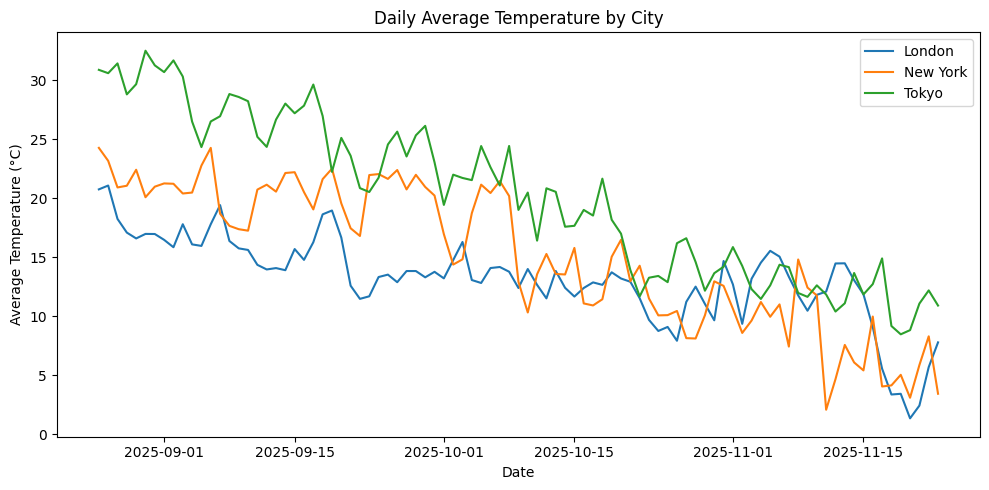

In [7]:
import matplotlib.pyplot as plt

# Sort just to be safe
pdf = pdf.sort_values(["city", "date"])

plt.figure(figsize=(10, 5))

for city, group in pdf.groupby("city"):
    plt.plot(group["date"], group["avg_temp_c"], label=city)

plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Daily Average Temperature by City")
plt.legend()
plt.tight_layout()
plt.show()


## 3. Wind speed patterns by city


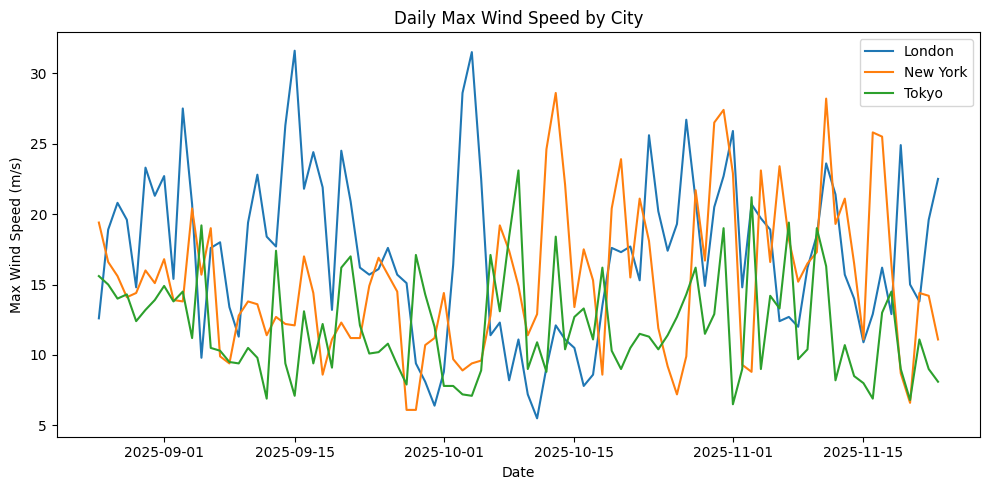

In [8]:
plt.figure(figsize=(10, 5))

for city, group in pdf.groupby("city"):
    plt.plot(group["date"], group["max_wind_speed_ms"], label=city)

plt.xlabel("Date")
plt.ylabel("Max Wind Speed (m/s)")
plt.title("Daily Max Wind Speed by City")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Extreme temperature days


In [9]:
from pyspark.sql.window import Window

w = Window.partitionBy("city").orderBy(F.col("max_temp_c").desc())

hottest_df = (
    df_gold
    .withColumn("rn", F.row_number().over(w))
    .filter("rn <= 5")
    .select("city", "date", "max_temp_c")
)

hottest_pdf = hottest_df.toPandas()
hottest_pdf


,city,date,max_temp_c
0,London,2025-08-25,26.1
1,London,2025-09-19,25.5
2,London,2025-08-26,25.3
3,London,2025-09-07,24.5
4,London,2025-09-06,22.1
5,New York,2025-08-25,31.5
6,New York,2025-09-06,30.0
7,New York,2025-10-05,29.7
8,New York,2025-09-14,29.6
9,New York,2025-09-23,29.4


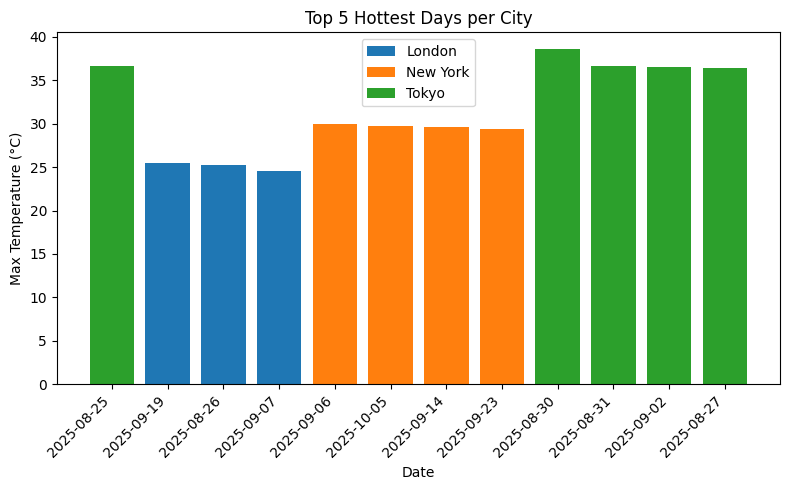

In [10]:
plt.figure(figsize=(8, 5))

for city, group in hottest_pdf.groupby("city"):
    plt.bar(
        group["date"].astype(str),
        group["max_temp_c"],
        label=city
    )

plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Max Temperature (°C)")
plt.title("Top 5 Hottest Days per City")
plt.legend()
plt.tight_layout()
plt.show()
